# Preparation

## Load libraries

In [1]:
# Stat libraries
import numpy as np
import pandas as pd
from math import dist

# Visualisation libraries
import seaborn as sns
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from yellowbrick.cluster import KElbowVisualizer

# Clustering toolkits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import silhouette_score
import category_encoders as ce

# Supportive libraries
from datetime import datetime

import warnings
warnings.simplefilter('ignore')


## Setting up plotting theme

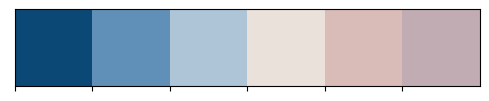

In [2]:
# Set matplotlib parameters
mp.rc_file_defaults()
rc = {'axes.facecolor':'white','grid.color': '.8',}
plt.rcParams.update(rc)

# Set Seaborn color palette
BlMa = ["#0c4876","#608fb7","#aec5d8","#e9e1da","#d9bbb8","#c2acb4"] # a customized Blue and Mauve color theme
BlMa_r = ["#c2acb4","#d9bbb8","#e9e1da","#aec5d8","#608fb7","#0c4876"]
sns.set_palette(sns.color_palette(BlMa)) 
sns.palplot(sns.color_palette(BlMa))

# Load Data

In [3]:
# Read xlsx file
exist_stores = pd.read_excel('Alias of 220622_Store_clustering.xlsx',
                             sheet_name = 'Existing_store_portfolio', 
                             index_col=0, 
                             header=0)

new_stores = pd.read_excel('Alias of 220622_Store_clustering.xlsx',
                             sheet_name = 'New_stores', 
                             index_col=0, 
                             header=0,
                             na_filter = True, 
                             usecols = 'A:L')

print("Data loaded with", len(exist_stores), "existing records and", len(new_stores), "new records." )

Data loaded with 46787 existing records and 24 new records.


# Initial Data Screening

In [4]:
exist_stores.head()

,Trade_class,Customer_parent,Division,APSW,Miles_per_delivery,Minutes_per_delivery,Deliveries_per_week,Dwell_time_per_delivery,Drop_size_per_delivery,%_cig_COGS,%_low_value_density_COGS
Store_ID,,,,,,,,,,,
A10001,Trade Class A,Company Name 10001,Division 3001,31565.433390,59.549249,64.149081,1.961538,52.275000,16092.181728,0.569998,0.089435
A10002,Trade Class A,Company Name 10001,Division 3001,25155.479659,30.969090,35.869188,1.980769,40.731576,12699.853808,0.662738,0.058137
A10003,Trade Class A,Company Name 10001,Division 3001,22525.635836,48.348914,51.244565,1.980769,52.152876,11372.165665,0.600005,0.080145
A10004,Trade Class A,Company Name 10001,Division 3001,22362.925053,49.766258,52.595969,1.980769,52.882353,11290.020415,0.489309,0.084781
A10005,Trade Class A,Company Name 10001,Division 3001,22287.479885,16.142759,18.708218,1.961538,46.629307,11362.244647,0.416810,0.103428


In [5]:
new_stores.head()

,Trade_class,Customer_parent,Division,APSW,Miles_per_delivery,Minutes_per_delivery,Deliveries_per_week,Dwell_time_per_delivery,Drop_size_per_delivery,%_cig_COGS,%_low_value_density_COGS
Store_ID,,,,,,,,,,,
A56788,Trade Class A,Company Name 10001,Division 3001,16055.526613,21.006574,26.434639,0.942308,66.023256,17038.518038,0.598549,0.057119
A56789,Trade Class C,Company Name 10018,Division 3001,25074.810984,11.378409,13.969316,2.000000,67.956771,12537.405492,0.349624,0.078083
A56790,Trade Class C,Company Name 10018,Division 3001,651.081262,23.631642,28.958723,1.500000,16.367487,434.054175,0.000000,0.000000
A56791,Trade Class E,Company Name 10037,Division 3001,18077.820764,18.930152,26.318733,1.807692,37.626069,10000.496593,0.034556,0.000000
A56792,Trade Class E,Company Name 10037,Division 3001,37384.005620,41.465462,49.576486,1.788462,31.119881,20902.884863,0.056145,0.000000


In [6]:
print("Existing store portfolio includes", exist_stores.shape[0], "records with", exist_stores.shape[1], "variables.")

Existing store portfolio includes 46787 records with 11 variables.


In [7]:
# Overview of data types
exist_stores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46787 entries, A10001 to A56787
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Trade_class               46787 non-null  object 
 1   Customer_parent           46787 non-null  object 
 2   Division                  46787 non-null  object 
 3   APSW                      46787 non-null  float64
 4   Miles_per_delivery        46787 non-null  float64
 5   Minutes_per_delivery      46787 non-null  float64
 6   Deliveries_per_week       46787 non-null  float64
 7   Dwell_time_per_delivery   46787 non-null  float64
 8   Drop_size_per_delivery    46787 non-null  float64
 9   %_cig_COGS                46787 non-null  float64
 10  %_low_value_density_COGS  46787 non-null  float64
dtypes: float64(8), object(3)
memory usage: 4.3+ MB


In [8]:
# Statistical characteristics
exist_stores.describe()

,APSW,Miles_per_delivery,Minutes_per_delivery,Deliveries_per_week,Dwell_time_per_delivery,Drop_size_per_delivery,%_cig_COGS,%_low_value_density_COGS
count,4.678700e+04,46787.000000,46787.000000,46787.000000,46787.000000,46787.000000,46787.000000,46787.000000
mean,1.090552e+04,31.726476,38.493295,1.359573,40.900521,7364.757554,0.389913,0.036435
std,2.164089e+04,28.545855,31.140275,0.554835,13.192300,9513.232422,0.225966,0.048178
min,1.142904e+01,0.004784,0.015544,0.250000,10.000000,26.400490,0.000000,0.000000
25%,3.455364e+03,16.357149,21.524510,0.980769,32.152883,3503.113944,0.215840,0.000000
50%,7.278997e+03,24.947898,31.629709,1.000000,38.997778,5495.452723,0.425012,0.000000
75%,1.441656e+04,38.077168,45.667117,1.980769,47.198162,9071.653220,0.555373,0.068013
max,1.780985e+06,576.261442,639.500642,5.980769,119.572889,630008.205988,1.000000,0.752851


In [9]:
# Detecting missing values
exist_stores.isna().sum()

Trade_class                 0
Customer_parent             0
Division                    0
APSW                        0
Miles_per_delivery          0
Minutes_per_delivery        0
Deliveries_per_week         0
Dwell_time_per_delivery     0
Drop_size_per_delivery      0
%_cig_COGS                  0
%_low_value_density_COGS    0
dtype: int64

In [10]:
# Detecting duplicate values
print("There are", exist_stores.duplicated().sum(), "duplicate values.")

There are 0 duplicate values.


In [11]:
# Amount of unique categorical variables
print("There are", len(np.unique(exist_stores['Trade_class'])), "unique Trade classes;")
print("There are", len(np.unique(exist_stores['Customer_parent'])), "unique Companies;")
print("There are", len(np.unique(exist_stores['Division'])), "unique Divisions.")

There are 12 unique Trade classes;
There are 119 unique Companies;
There are 1 unique Divisions.


Observations:  
    1. Data contains **46787** rows and **11** columns<br>
    2. It has **8** float and **3** object columns<br>
    3. Categorical variables need to be cleaned and converted<br>
    4. There are 12 unique Trade classes, 119 unique companies and only 1 division.<br>
    5. There are **no missing values** within data<br>
    6. There are **no duplicate values** within data<br>
    Overall, high quality data with a mixed nature of categorical and quantitative variables.<br>

# Data Cleaning and Feature Construction

## Feature Engeerning

In [12]:
# For convinience, we rename the Dataframe of exist_stores into df
df = exist_stores

# Eliminating prefix of categorical variables
df['Trade_class'] = df['Trade_class'].str[-1]
df['Customer_parent'] = df['Customer_parent'].str[-5:]
df['Division'] = df['Division'].str[-4:]

df.head()

,Trade_class,Customer_parent,Division,APSW,Miles_per_delivery,Minutes_per_delivery,Deliveries_per_week,Dwell_time_per_delivery,Drop_size_per_delivery,%_cig_COGS,%_low_value_density_COGS
Store_ID,,,,,,,,,,,
A10001,A,10001,3001,31565.433390,59.549249,64.149081,1.961538,52.275000,16092.181728,0.569998,0.089435
A10002,A,10001,3001,25155.479659,30.969090,35.869188,1.980769,40.731576,12699.853808,0.662738,0.058137
A10003,A,10001,3001,22525.635836,48.348914,51.244565,1.980769,52.152876,11372.165665,0.600005,0.080145
A10004,A,10001,3001,22362.925053,49.766258,52.595969,1.980769,52.882353,11290.020415,0.489309,0.084781
A10005,A,10001,3001,22287.479885,16.142759,18.708218,1.961538,46.629307,11362.244647,0.416810,0.103428


In [13]:
# Creating new features based on the current variables

# Calculating the total mileage every week: Miles_per_week
df['Miles_per_week'] = df['Miles_per_delivery'] * df['Deliveries_per_week']

# Calculating the overall time spent on delivery every week: Total_time_per_week
df['Total_time_per_week'] = (df['Minutes_per_delivery'] + df['Dwell_time_per_delivery']) * df['Deliveries_per_week']

<AxesSubplot:>

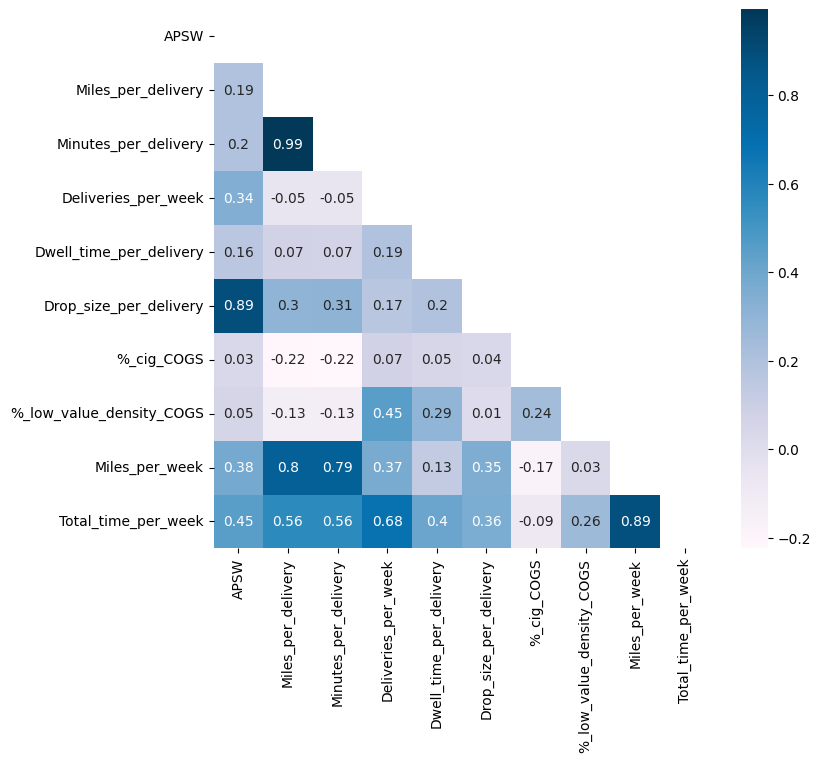

In [14]:
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize = (8,7))
sns.heatmap(df.corr(),cmap = 'PuBu', annot=round(df.corr(),2), fmt='', mask = mask)

In [15]:
# We drop the Division column as all stores belong to one division thus it has no statitical contribution to following analysis.
df.drop(['Division'], axis = 1, inplace = True)

## Outlier Removal

Now we need to check the distribution of values in the dataset to remove any outliers.

In [16]:
# Check skewness
df.skew()

Customer_parent              0.727257
APSW                        33.961733
Miles_per_delivery           4.967312
Minutes_per_delivery         4.950243
Deliveries_per_week          0.551876
Dwell_time_per_delivery      1.043496
Drop_size_per_delivery      20.838861
%_cig_COGS                  -0.127666
%_low_value_density_COGS     1.594971
Miles_per_week              11.315783
Total_time_per_week          6.774095
dtype: float64

 If the skewness is between **-0.5** and **0.5**, the data are fairly **symmetrical**. If the skewness is between **-1** and **-0.5** or between **0.5** and **1**, the data are **moderately skewed**. If the skewness is **less than -1** or **greater than 1**, the data are **highly skewed**. <br>   
 Therefore, only %_cig_COGS is fairly sysmetrical, all other variables are **moderately to highly skewed**.

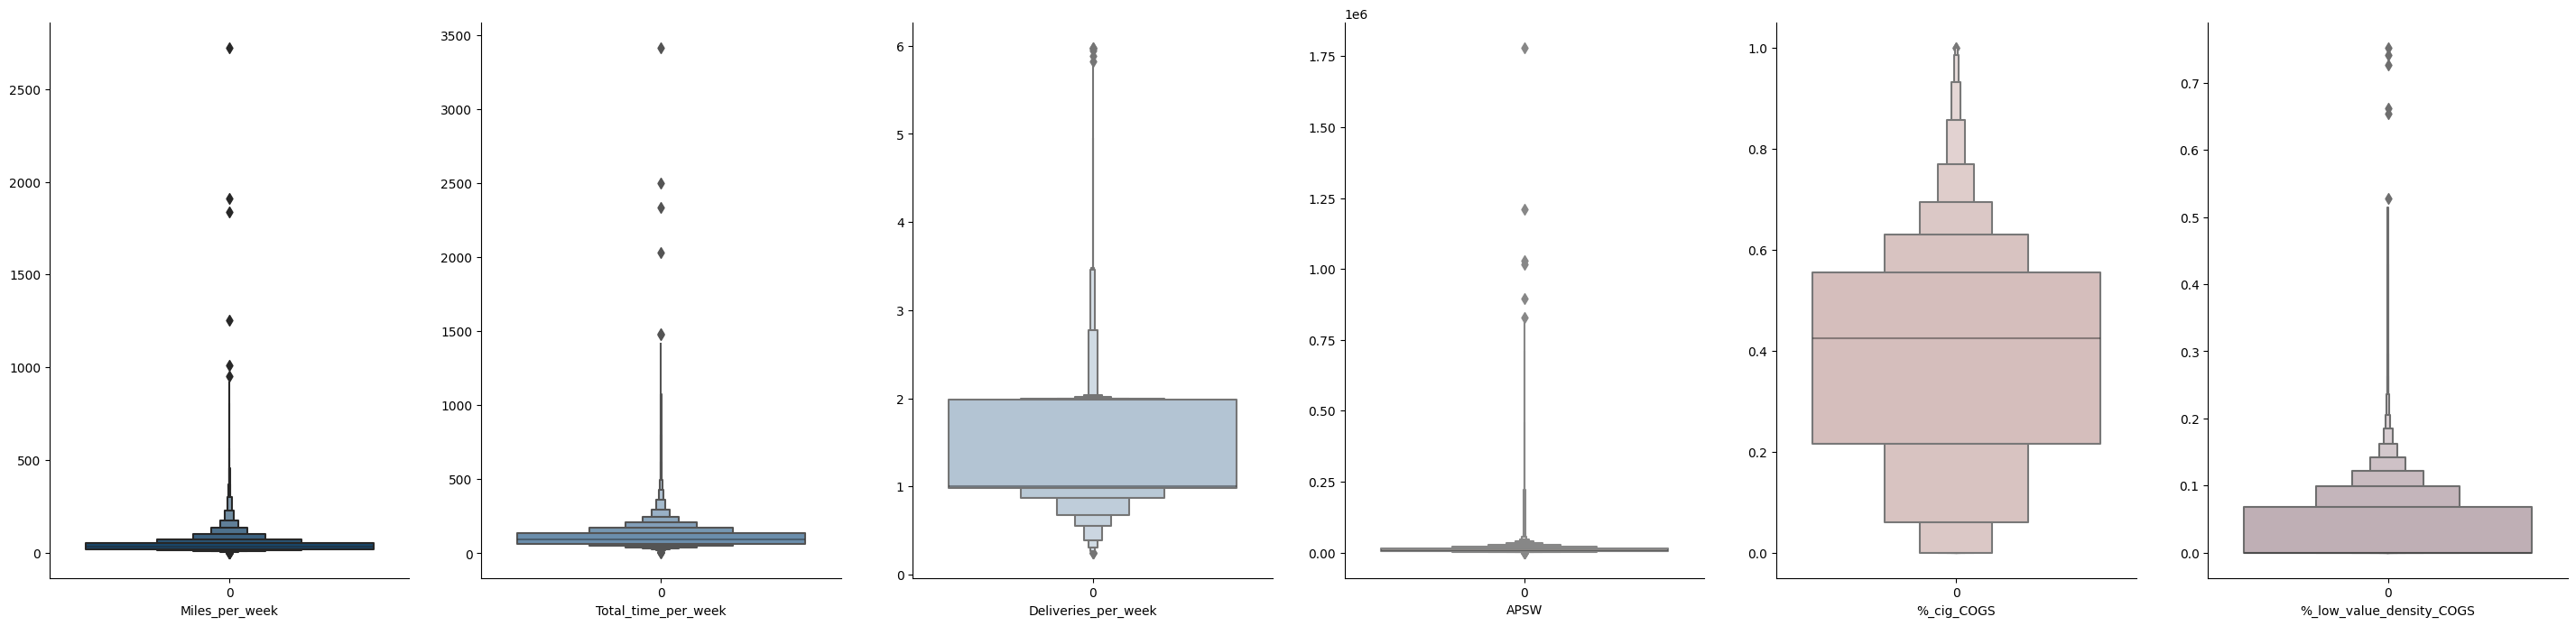

In [17]:
#examine the boxplots of different features
features= ['Miles_per_week','Total_time_per_week','Deliveries_per_week','APSW','%_cig_COGS','%_low_value_density_COGS']

#create plots
fig, axs = plt.subplots(ncols=len(features),figsize=(6*len(features),8))
for i in range(len(features)):
  sns.boxenplot(data=df[features[i]],
                showfliers=True,
                ax=axs[i],
                palette=[BlMa[i]]
                ).set(xlabel=features[i])
  sns.despine()

As expected from the skewness analysis, some of the major variables has significant outliers.

Here we apply capping method to remove outliers.

In [18]:
# Record column names for later use
num_col = df.select_dtypes(include = 'float64').columns

In [19]:
# Capping skewed numerical data based on Inter-Quartile Range (IQR) proximity rule
row_drop_count = 0
for col in num_col:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    ll = q1-(3*iqr)
    ul = q3+(3*iqr)
    for ind in df[col].index:
        if df.loc[ind,col]>ul:
            df.drop(index = ind, inplace = True)
            row_drop_count =+1
        elif df.loc[ind,col]<ll:
            df.drop(index = ind, inplace = True)
            row_drop_count =+1
        else:
            pass
print("Outliers have been taken care of.")
print("Totally", row_drop_count, "rows have been dropped, which count for", round(row_drop_count/exist_stores.shape[0],2), "% of all data.")

Outliers have been taken care of.
Totally 1 rows have been dropped, which count for 0.0 % of all data.


Now let's recheck the shape of the data set.

In [20]:
df.shape

(44214, 12)

## Encoding Categorical Features

The 2 categorial features we have can be encoded as follows:

    1.Trade_class: using one hot encoding since it's considered nominal and has less than 15 unique values.

    2.Customer_parent: using hashing encoding since it's considered nominal but has very high cardinality (over 100 unique values).

In [21]:
# One hot encode trade class
df_onehot = pd.get_dummies(df['Trade_class'], drop_first= True)

# Hashing encode company names
encoder= ce.HashingEncoder()
df_hash= encoder.fit_transform(df['Customer_parent'])

print('The data has been encoded successfully!')

The data has been encoded successfully!


In [22]:
# check data
df1 = pd.concat([df,df_onehot,df_hash], axis=1)
df1.drop(['Trade_class','Customer_parent'] ,axis = 1, inplace=True)
df1.head()

,APSW,Miles_per_delivery,Minutes_per_delivery,Deliveries_per_week,Dwell_time_per_delivery,Drop_size_per_delivery,%_cig_COGS,%_low_value_density_COGS,Miles_per_week,Total_time_per_week,...,K,L,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
Store_ID,,,,,,,,,,,,,,,,,,,,,
A10001,31565.433390,59.549249,64.149081,1.961538,52.275000,16092.181728,0.569998,0.089435,116.808142,228.370313,...,0,0,0,1,0,0,0,0,0,0
A10002,25155.479659,30.969090,35.869188,1.980769,40.731576,12699.853808,0.662738,0.058137,61.342621,151.728436,...,0,0,0,1,0,0,0,0,0,0
A10003,22525.635836,48.348914,51.244565,1.980769,52.152876,11372.165665,0.600005,0.080145,95.768041,204.806469,...,0,0,0,1,0,0,0,0,0,0
A10004,22362.925053,49.766258,52.595969,1.980769,52.882353,11290.020415,0.489309,0.084781,98.575473,208.928215,...,0,0,0,1,0,0,0,0,0,0
A10005,22287.479885,16.142759,18.708218,1.961538,46.629307,11362.244647,0.416810,0.103428,31.664643,128.162069,...,0,0,0,1,0,0,0,0,0,0


## Scaling Numerical Features

In [23]:
# Scaling all the numeric columns
num_cols = ['APSW', 'Miles_per_delivery', 'Minutes_per_delivery',
       'Deliveries_per_week', 'Dwell_time_per_delivery',
       'Drop_size_per_delivery', '%_cig_COGS', '%_low_value_density_COGS',
       'Miles_per_week', 'Total_time_per_week']
scaler = StandardScaler()

# Create copy of the dataframe for later use
scaled_df = df1.copy()
scaled_df[num_cols] = scaler.fit_transform(scaled_df[num_cols])
print('The data has been scaled successfully!')

The data has been scaled successfully!


In [24]:
#check data
scaled_df.head()

,APSW,Miles_per_delivery,Minutes_per_delivery,Deliveries_per_week,Dwell_time_per_delivery,Drop_size_per_delivery,%_cig_COGS,%_low_value_density_COGS,Miles_per_week,Total_time_per_week,...,K,L,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
Store_ID,,,,,,,,,,,,,,,,,,,,,
A10001,2.792363,1.993989,1.712185,1.148547,0.955229,2.273968,0.785335,1.133100,3.306282,2.585204,...,0,0,0,1,0,0,0,0,0,0
A10002,1.983686,0.210318,0.105289,1.184523,0.032729,1.471898,1.205992,0.465040,1.034134,1.037955,...,0,0,0,1,0,0,0,0,0,0
A10003,1.651906,1.294982,0.978936,1.184523,0.945470,1.157984,0.921443,0.934796,2.444373,2.109496,...,0,0,0,1,0,0,0,0,0,0
A10004,1.631378,1.383438,1.055724,1.184523,1.003766,1.138562,0.419342,1.033761,2.559379,2.192706,...,0,0,0,1,0,0,0,0,0,0
A10005,1.621860,-0.714985,-0.869817,1.148547,0.504050,1.155638,0.090495,1.431797,-0.181626,0.562196,...,0,0,0,1,0,0,0,0,0,0


# Data Clustering

## Optimal Number of Clusters

* Before applying the K-Means algorithm we need to decide how many clusters we would like to have using Within Clusters Sum of Squares(WCSS) or Elbow Method and Silhouette Score for validation.  
* Visualize the elbow plot and silhouette plot to choose the number of clusters  

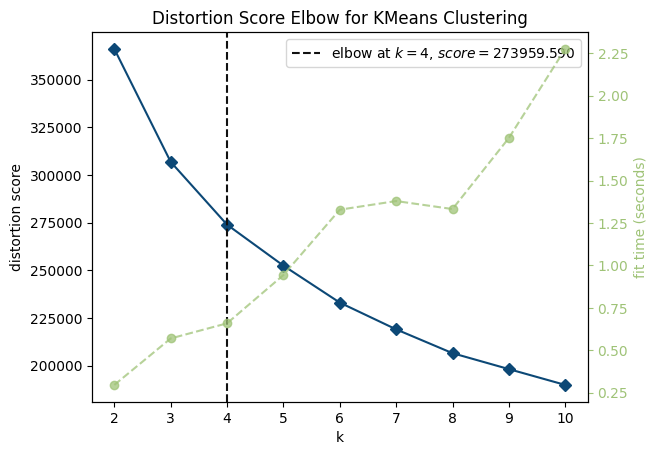

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
elbow_graph = KElbowVisualizer(KMeans(random_state=43), k=10)
elbow_graph.fit(scaled_df)
elbow_graph.show()

Elbow plot gives the optimal cluster number at **k = 4**, we will be using it in the following practice.

In [26]:
clusters = [2,3,4,5,6,7,8,9,10] # number of clusters
s_scores = [] # silhouette scores

for n in clusters:
    kmeans = KMeans(n_clusters = n, random_state=43).fit(scaled_df)
    silhouette = silhouette_score(scaled_df, kmeans.labels_)
    s_scores.append(silhouette)

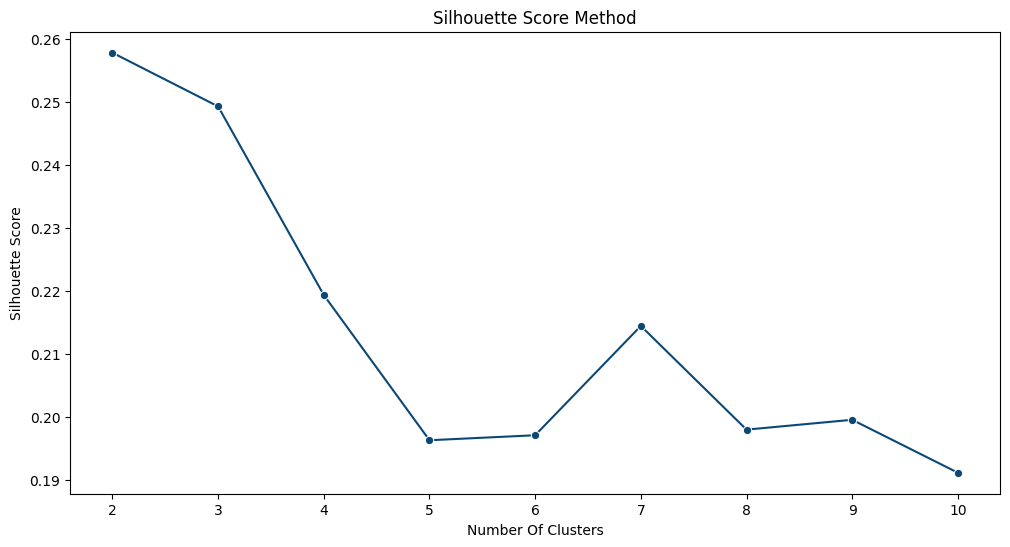

In [27]:
plt.figure(figsize=(12,6))
sns.lineplot(clusters, s_scores, marker='o',color= BlMa[0])
plt.title('Silhouette Score Method')
plt.xlabel('Number Of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

## PCA

* Part of the reason we are seeing low Silhouette score is because we are having too many features. 
* So next step we will do dimension reduction. Dimension reduction is the process of reducing the number of said random variables by obtaining a set of fundamental variables.
* Principal Component Analysis (PCA) is a common method for dimension reduction.

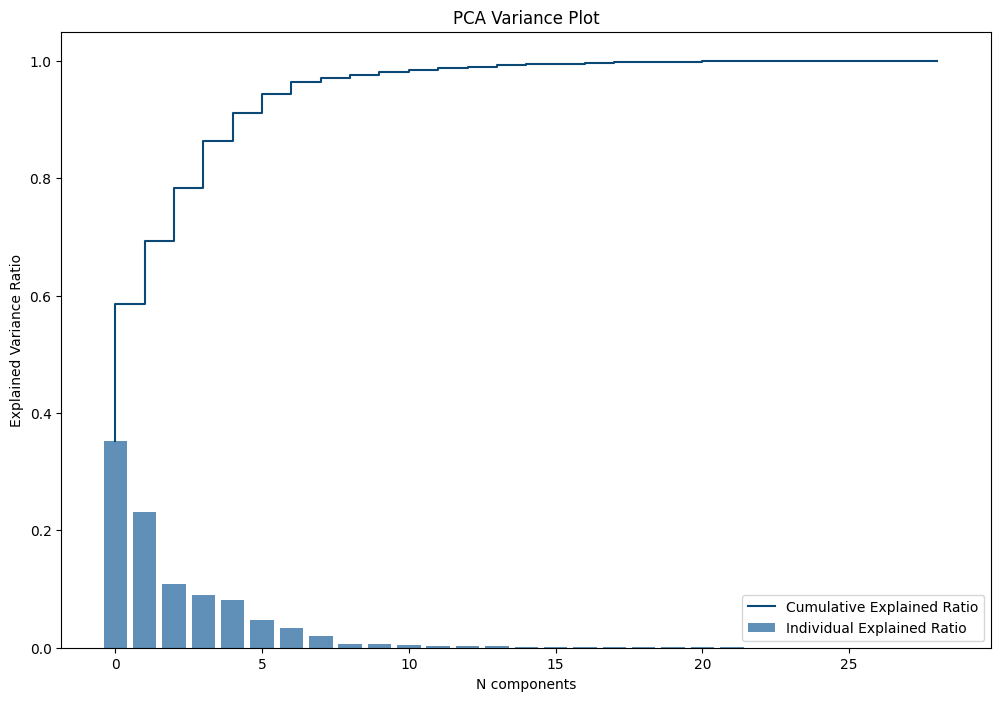

In [28]:
pca = PCA()
pca.fit(scaled_df)

cum_sum_eigenvalues = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(12, 8))
plt.bar(range(0, len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, label="Individual Explained Ratio", color = BlMa[1])
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, label="Cumulative Explained Ratio", color = BlMa[0])
plt.title('PCA Variance Plot')
plt.xlabel("N components")
plt.ylabel("Explained Variance Ratio")
plt.legend(loc="best")
plt.show()

In [29]:
#75% variations
pca = PCA(n_components = 0.75)
pca.fit(scaled_df)
reduced_df = pd.DataFrame(pca.transform(scaled_df))

print("Current number of features= ",len(reduced_df.columns))

Current number of features=  4


* It appears that only **4 principal components** already explain **0.79** of the variance of the dataset.  
* Let's calculate Silhouette score again using the data with reduced dimensionality.

In [30]:
clusters = [2,3,4,5,6,7,8,9,10] # number of clusters
s_scores = [] # silhouette scores

for n in clusters:
    kmeans = KMeans(n_clusters = n, random_state=43).fit(reduced_df)
    silhouette = silhouette_score(reduced_df, kmeans.labels_)
    s_scores.append(silhouette)

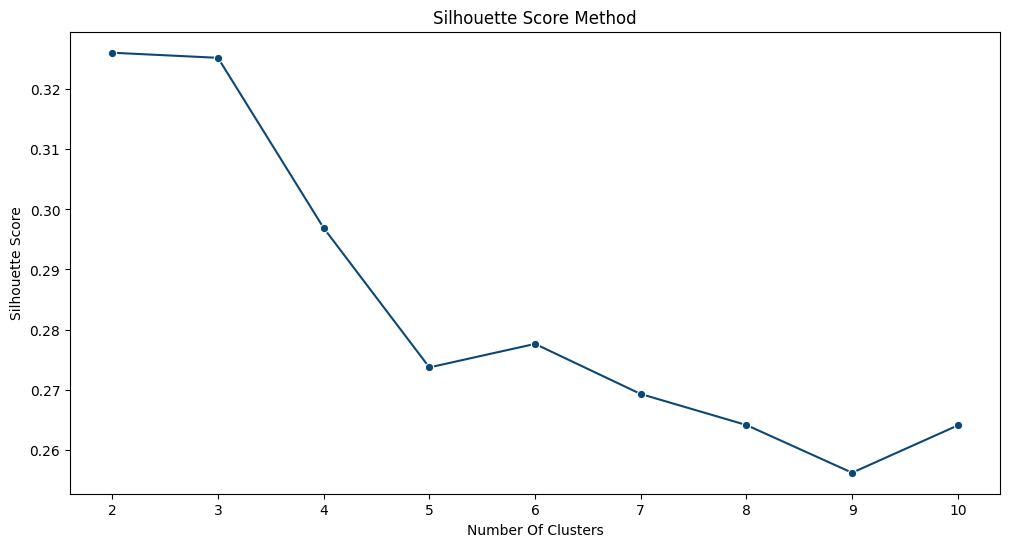

In [31]:
plt.figure(figsize=(12,6))
sns.lineplot(clusters, s_scores, marker='o',color= BlMa[0])
plt.title('Silhouette Score Method')
plt.xlabel('Number Of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

* The Silhouette score increased by 0.07 for cluster number of 4. Nothing significant, but better than no improvement.
* Now we have a reduced dataset and a optimal cluster number of 4, we can start the clustering.

## K-Means Clustering

In [32]:
# Deploy K-means clustering with class number = 4
kmeans = KMeans(n_clusters=4, random_state=42)
df['Clusters'] = kmeans.fit_predict(reduced_df)
df.head()

,Trade_class,Customer_parent,APSW,Miles_per_delivery,Minutes_per_delivery,Deliveries_per_week,Dwell_time_per_delivery,Drop_size_per_delivery,%_cig_COGS,%_low_value_density_COGS,Miles_per_week,Total_time_per_week,Clusters
Store_ID,,,,,,,,,,,,,
A10001,A,10001,31565.433390,59.549249,64.149081,1.961538,52.275000,16092.181728,0.569998,0.089435,116.808142,228.370313,3
A10002,A,10001,25155.479659,30.969090,35.869188,1.980769,40.731576,12699.853808,0.662738,0.058137,61.342621,151.728436,3
A10003,A,10001,22525.635836,48.348914,51.244565,1.980769,52.152876,11372.165665,0.600005,0.080145,95.768041,204.806469,3
A10004,A,10001,22362.925053,49.766258,52.595969,1.980769,52.882353,11290.020415,0.489309,0.084781,98.575473,208.928215,3
A10005,A,10001,22287.479885,16.142759,18.708218,1.961538,46.629307,11362.244647,0.416810,0.103428,31.664643,128.162069,0


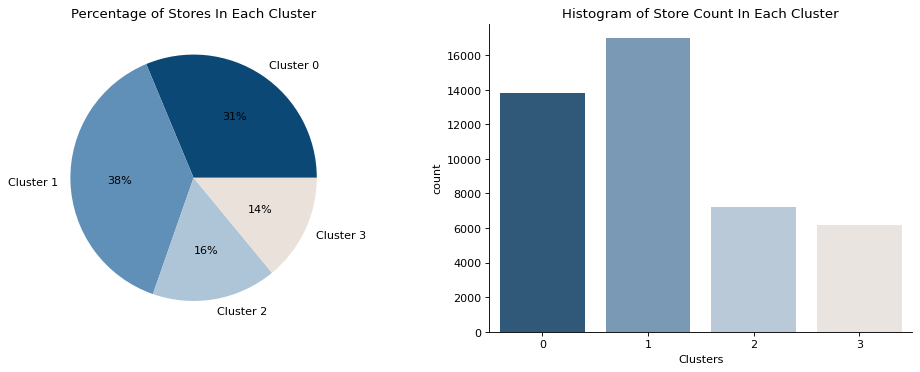

In [33]:
# Define labels
labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
counts= []

# Compute counts
for i in range(4):
  counts.append(len(df[df['Clusters']==i]))

plt.figure(figsize=(15, 5), dpi=80)
plt.rcParams.update({'axes.grid': False})

# Pie plot
ax1 = plt.subplot2grid((1,2),(0,0))
ax1.set_title("Percentage of Stores In Each Cluster")
plt.pie(counts, labels = labels, autopct='%.0f%%')

# Count plot
ax1 = plt.subplot2grid((1,2), (0, 1))
ax1.set_title("Histogram of Store Count In Each Cluster")
sns.countplot(x=df['Clusters'], alpha=.9, ax=ax1)
sns.despine()

plt.show()


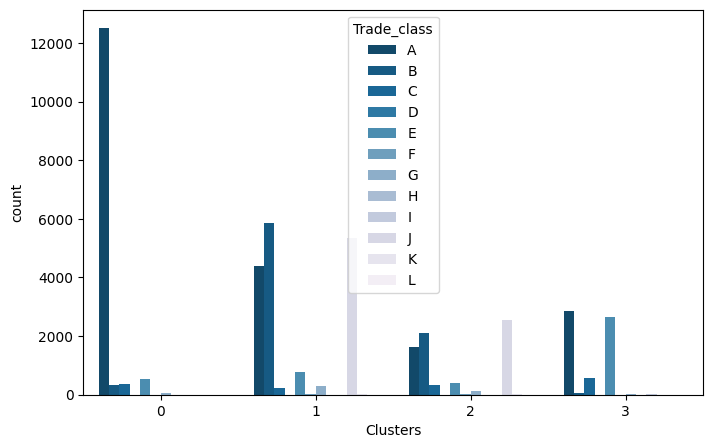

In [34]:
# Lets see how many stores from each cluster has what Trade_class
plt.figure(figsize=(8, 5))
plt.rcParams.update({'axes.grid': False})
sns.countplot(x='Clusters', data=df, hue='Trade_class',palette= 'PuBu_r' )
plt.show()

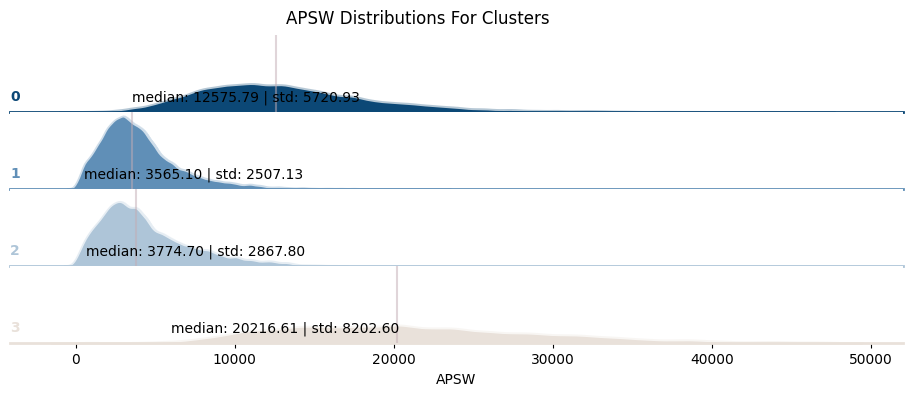

In [35]:
# Initialize the FacetGrid object
g = sns.FacetGrid(df,
                  row='Clusters',
                  hue='Clusters',
                  size= 1, aspect=10,
                  # palette=BlMa
                  )

# Draw the densities in a few steps
g.map(sns.kdeplot, 'APSW',
      bw_adjust=.5, 
      clip_on=False,
      fill=True, 
      alpha=1, 
      linewidth=1.5)

g.map(sns.kdeplot, 'APSW', 
      clip_on=False, 
      color='w', 
      lw=2, 
      bw_adjust=.5,
      alpha=.7)

# Passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle='-', color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(APSW, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight='bold', color=color,
            ha='left', va='center', transform=ax.transAxes)

g.map(label, 'APSW')

# Add vertical lines for mean age on each plot
def vertical_mean_line_survived(x, **kwargs):
    plt.axvline(x.median(), linestyle ="-", 
                color = BlMa[-1], alpha=.5)
    txkw = dict(size=10, color = BlMa[-1])
    tx = "median: {:.2f} | std: {:.2f}".format(x.median(),x.std())
    ax = plt.gca()
    ax.text(0.06+x.mean()/175000, .2, tx, color="black", size= 10,
            ha="left", va="center", transform=ax.transAxes)
g.map(vertical_mean_line_survived, 'APSW')


# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0.01)

# Remove axes details that don't play well with overlap
g.fig.suptitle("APSW Distributions For Clusters")
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

<Figure size 400x400 with 0 Axes>

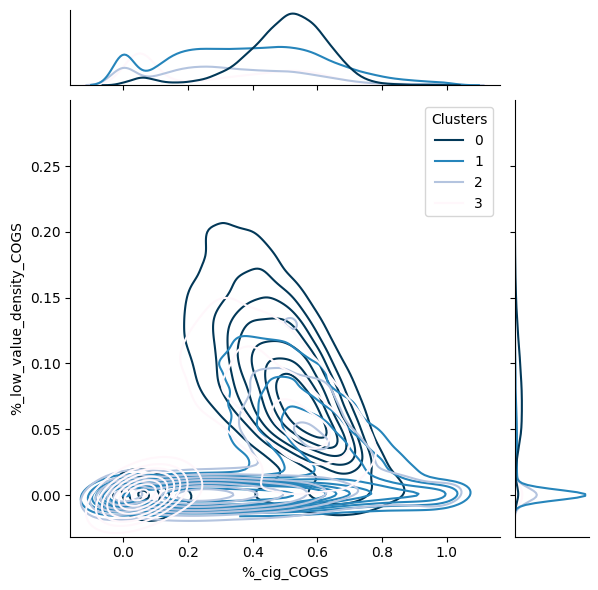

In [36]:
# Show the joint distribution using kernel density estimation
plt.figure(figsize=(5, 5), dpi=80)
g = sns.jointplot(data=df, x='%_cig_COGS', y='%_low_value_density_COGS', hue='Clusters',kind='kde',palette= 'PuBu_r')
sns.despine()

# Calculating similarity

## Predicting Clusters for New Stores

There are many ways to assign clusters for new data. Since we only have few new data points, the built-in predict() function would be the most convient way to do so.

New dataset needs to go over the same data cleaning and feature construction process as the exsiting data


In [40]:
# Rename the new stores dataframe
df_new = new_stores

# Eliminating prefix of categorical variables
df_new['Trade_class'] = df_new['Trade_class'].str[-1]
df_new['Customer_parent'] = df_new['Customer_parent'].str[-5:]

# Dropping Division
df_new.drop('Division',axis =1, inplace = True)

# Calculating the total mileage every week: Miles_per_week
df_new['Miles_per_week'] = df_new['Miles_per_delivery'] * df_new['Deliveries_per_week']

# Calculating the overall time spent on delivery every week: Total_time_per_week
df_new['Total_time_per_week'] = (df_new['Minutes_per_delivery'] + df_new['Dwell_time_per_delivery']) * df_new['Deliveries_per_week']

# Encoding Categorical Features
# One hot encode trade class
df_new_onehot = pd.get_dummies(df_new['Trade_class'], drop_first= True)

# Hashing encode company names
encoder= ce.HashingEncoder()
df_new_hash= encoder.fit_transform(df_new['Customer_parent'])

# Scaling Numerical Features
# Scaling all the numeric columns
num_cols = ['APSW', 'Miles_per_delivery', 'Minutes_per_delivery',
       'Deliveries_per_week', 'Dwell_time_per_delivery',
       'Drop_size_per_delivery', '%_cig_COGS', '%_low_value_density_COGS',
       'Miles_per_week', 'Total_time_per_week']
scaler = StandardScaler()

df_new1 = pd.concat([df_new,df_new_onehot,df_new_hash], axis=1)
df_new1.drop(['Trade_class','Customer_parent'] ,axis = 1, inplace=True)

# Create copy of the dataframe for later use
scaled_df_new = df_new1.copy()
scaled_df_new[num_cols] = scaler.fit_transform(scaled_df_new[num_cols])

In [41]:
# Check new data
scaled_df_new.head()

,APSW,Miles_per_delivery,Minutes_per_delivery,Deliveries_per_week,Dwell_time_per_delivery,Drop_size_per_delivery,%_cig_COGS,%_low_value_density_COGS,Miles_per_week,Total_time_per_week,...,I,J,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
Store_ID,,,,,,,,,,,,,,,,,,,,,
A56788,0.282957,-0.382936,-0.385509,-0.818276,1.690035,1.376752,1.046689,0.453439,-0.483398,-0.259073,...,0,0,0,1,0,0,0,0,0,0
A56789,1.024324,-0.867763,-0.959125,1.395094,1.826791,0.637891,-0.065230,0.882768,-0.407235,0.949916,...,0,0,0,0,0,0,0,0,1,0
A56790,-0.983259,-0.250751,-0.269359,0.348773,-1.822088,-1.348884,-1.626966,-0.716360,-0.080933,-0.560569,...,0,0,0,0,0,0,0,0,1,0
A56791,0.449185,-0.487495,-0.390843,0.992663,-0.318481,0.221455,-1.472609,-0.716360,-0.112496,0.189502,...,0,0,0,0,0,0,0,0,1,0
A56792,2.036116,0.647271,0.679406,0.952420,-0.778660,2.011091,-1.376174,-0.716360,0.914430,0.642190,...,0,0,0,0,0,0,0,0,1,0


In [42]:
# Dimension reduction
pca = PCA(n_components = 4)
pca.fit(scaled_df_new)
reduced_df_new = pd.DataFrame(pca.transform(scaled_df_new))
reduced_df_new.head()

,0,1,2,3
0,-0.202006,0.800427,-2.230827,0.909822
1,0.799079,2.853040,-0.269123,1.348602
2,-1.067486,-0.702192,2.753756,-0.486906
3,0.586287,0.651169,2.013242,0.615032
4,3.143611,0.203580,1.504172,-0.176895


In [43]:
# Predict clusters with new data
df_new['Clusters'] = kmeans.predict(reduced_df_new)

In [44]:
df_new.head()

,Trade_class,Customer_parent,APSW,Miles_per_delivery,Minutes_per_delivery,Deliveries_per_week,Dwell_time_per_delivery,Drop_size_per_delivery,%_cig_COGS,%_low_value_density_COGS,Miles_per_week,Total_time_per_week,Clusters
Store_ID,,,,,,,,,,,,,
A56788,A,10001,16055.526613,21.006574,26.434639,0.942308,66.023256,17038.518038,0.598549,0.057119,19.794656,87.123785,2
A56789,C,10018,25074.810984,11.378409,13.969316,2.000000,67.956771,12537.405492,0.349624,0.078083,22.756818,163.852175,2
A56790,C,10018,651.081262,23.631642,28.958723,1.500000,16.367487,434.054175,0.000000,0.000000,35.447463,67.989316,1
A56791,E,10037,18077.820764,18.930152,26.318733,1.807692,37.626069,10000.496593,0.034556,0.000000,34.219890,115.592527,2
A56792,E,10037,37384.005620,41.465462,49.576486,1.788462,31.119881,20902.884863,0.056145,0.000000,74.159383,144.322349,3


## Calculating Euclidean Distance

The spatial information are recorded in the eigenvalues of each feature space. Therefore, we can use **reduced_df** and **reduced_df_new** to calculate the norm between two points, which is the Euclidean distance.  
The smaller the Euclidean distance, the more similar two data points are.

In [45]:
# Check if we have correct dimentionality of the existing data
reduced_df.shape

(44214, 4)

In [46]:
# Check if we have correct dimentionality of the new data
reduced_df_new.shape

(24, 4)

Note, it is essential to have the same feature numbers between two dataframes. 

In [47]:
# Calculating all possible Euclidean Distance between points
edist = np.empty([len(reduced_df),len(reduced_df_new)])
for i in range(0,len(reduced_df_new)): 
    for j in range(0,len(reduced_df)):
        edist[j][i] = dist(reduced_df.iloc[j],reduced_df_new.iloc[i])

# Converting list of lists into DataFrame
df_edist = pd.DataFrame(edist,columns = df_new.index)

# Check the Euclidean Distance Dataframe
df_edist.head()

Store_ID,A56788,A56789,A56790,A56791,A56792,A56793,A56794,A56795,A56796,A56797,...,A56802,A56803,A56804,A56805,A56806,A56807,A56808,A56809,A56810,A56811
0,6.637481,5.723035,8.154275,6.043873,3.834803,5.514994,5.871277,8.205672,8.703031,4.160316,...,7.707202,8.186573,6.964965,6.221516,7.205498,4.890042,7.518671,7.805324,8.273629,8.383861
1,4.359736,4.441074,4.895514,3.334746,2.285334,3.057678,4.720161,5.781260,6.272009,6.839123,...,4.079314,5.117729,4.110643,4.109093,4.137066,2.709201,4.032533,4.577435,5.228334,5.002608
2,4.802141,4.529019,6.736377,4.802028,2.866214,4.362244,4.436238,6.582381,7.027762,5.318488,...,5.929720,6.404640,5.134269,4.691378,5.263213,2.965946,5.692563,6.102519,6.314308,6.442657
3,4.954224,4.584782,6.792219,4.872763,2.790146,4.390867,4.319996,6.522915,6.983722,5.179710,...,6.113411,6.499831,5.201514,4.716557,5.470342,2.940880,5.788019,6.315618,6.359236,6.537321
4,4.541634,5.503557,4.058874,3.708775,3.237330,3.572713,5.244954,5.295090,5.758042,7.884136,...,3.153298,4.536534,3.702371,4.529436,3.633385,2.641573,2.634721,4.377117,3.970102,3.416478


In [48]:
# Restore the Store_ID for both existing stores and new stores for further documentation
df_edist.reset_index
df_edist['Store_ID'] = scaled_df.index
df_edist.set_index('Store_ID', inplace=True)
df_edist.head()

Store_ID,A56788,A56789,A56790,A56791,A56792,A56793,A56794,A56795,A56796,A56797,...,A56802,A56803,A56804,A56805,A56806,A56807,A56808,A56809,A56810,A56811
Store_ID,,,,,,,,,,,,,,,,,,,,,
A10001,6.637481,5.723035,8.154275,6.043873,3.834803,5.514994,5.871277,8.205672,8.703031,4.160316,...,7.707202,8.186573,6.964965,6.221516,7.205498,4.890042,7.518671,7.805324,8.273629,8.383861
A10002,4.359736,4.441074,4.895514,3.334746,2.285334,3.057678,4.720161,5.781260,6.272009,6.839123,...,4.079314,5.117729,4.110643,4.109093,4.137066,2.709201,4.032533,4.577435,5.228334,5.002608
A10003,4.802141,4.529019,6.736377,4.802028,2.866214,4.362244,4.436238,6.582381,7.027762,5.318488,...,5.929720,6.404640,5.134269,4.691378,5.263213,2.965946,5.692563,6.102519,6.314308,6.442657
A10004,4.954224,4.584782,6.792219,4.872763,2.790146,4.390867,4.319996,6.522915,6.983722,5.179710,...,6.113411,6.499831,5.201514,4.716557,5.470342,2.940880,5.788019,6.315618,6.359236,6.537321
A10005,4.541634,5.503557,4.058874,3.708775,3.237330,3.572713,5.244954,5.295090,5.758042,7.884136,...,3.153298,4.536534,3.702371,4.529436,3.633385,2.641573,2.634721,4.377117,3.970102,3.416478


## Calculating Smilarity Score

As mentioned above, the closer/smaller Euclidean Distance, the more similar two data points are. Therefore, for interpretive purpose, we can use the **reciprocal** for Euclidean distances to represent the **similarity score**. 

In [49]:
# Build a function to output store_id, similarity score, and belonging cluster
def similar_stores(store_id, n):
    closest = df_edist.nsmallest(n, store_id)[store_id]
    similarity = []
    for k in range(0,n):
        similarity.append(closest.index[k])
        cluster = df.loc[closest.index[k],'Clusters']
        similarity.append(1/closest[k]) # reciprocal for Euclidean Distance
        similarity.append(cluster)
    return similarity

In [50]:
# Let's take a look at the top 5 similar stores we found for one new store
similar_stores('A56788',5)

['A10570',
 1.7719404739734084,
 2,
 'A55886',
 1.6167055656701108,
 2,
 'A30385',
 1.559639748162531,
 2,
 'A10539',
 1.5487425436398687,
 2,
 'A12054',
 1.5375742481465222,
 2]

In [51]:
# Now we can expand this result metrix to all new stores
columns = ['Store_ID 1','Similarity_Score 1','Cluster 1',
          'Store_ID 2','Similarity_Score 2','Cluster 2',
          'Store_ID 3','Similarity_Score 3','Cluster 3',
          'Store_ID 4','Similarity_Score 4','Cluster 4',
          'Store_ID 5','Similarity_Score 5','Cluster 5',
          'Store_ID 6','Similarity_Score 6','Cluster 6',
          'Store_ID 7','Similarity_Score 7','Cluster 7',
          'Store_ID 8','Similarity_Score 8','Cluster 8',
          'Store_ID 9','Similarity_Score 9','Cluster 9',
          'Store_ID 10','Similarity_Score 10','Cluster 10'
          ]
df_simscore = pd.DataFrame(columns = columns, index = df_new.index)
for ind in df_new.index:
    df_simscore.loc[ind] = similar_stores(ind,10)

# Exam the output
df_simscore.head()

,Store_ID 1,Similarity_Score 1,Cluster 1,Store_ID 2,Similarity_Score 2,Cluster 2,Store_ID 3,Similarity_Score 3,Cluster 3,Store_ID 4,...,Cluster 7,Store_ID 8,Similarity_Score 8,Cluster 8,Store_ID 9,Similarity_Score 9,Cluster 9,Store_ID 10,Similarity_Score 10,Cluster 10
Store_ID,,,,,,,,,,,,,,,,,,,,,
A56788,A10570,1.77194,2,A55886,1.616706,2,A30385,1.55964,2,A10539,...,2,A10526,1.376439,2,A23007,1.369932,2,A46051,1.352472,2
A56789,A31441,3.745131,2,A12929,3.007467,2,A47770,2.51441,2,A47790,...,2,A21261,1.889273,2,A20724,1.862491,2,A10934,1.811688,2
A56790,A40025,4.141309,1,A40161,1.942934,1,A19856,1.785415,1,A19963,...,1,A39981,1.556844,1,A19701,1.518476,1,A40248,1.499447,1
A56791,A22192,1.425691,0,A40082,1.300471,1,A19820,1.297341,1,A13965,...,2,A19842,1.247455,2,A16495,1.228671,3,A16501,1.178434,2
A56792,A18677,1.801584,3,A14832,1.411311,3,A14834,1.31991,3,A18428,...,3,A14839,1.121231,3,A16349,1.108388,3,A18679,1.094257,3


In [52]:
# Export result as .csv file
df_simscore.to_csv('similary score.csv')

# Conclusions

* Overall, most of the top 10 similar stores fall into the same clusters as the new stores. This result validated the feasibility and accuracy of our clusteirng method. 
* Some stores, for example, A56791, are having peer stores from all clusters which indicating lost of variance during dimension reduction. Other unsupervised clustering methods like fuzzy means or even supervised methods can be considered to complement K-means clustering method.
